# Import data

In [52]:
import pandas as pd

# Read all sheets into a dictionary of DataFrames
dfs = pd.read_excel('experiment-a-b.xlsx', sheet_name=None)

# Print the names of the sheets
print(dfs.keys())

dict_keys(['Δ𝜂 > 0 in X', 'Δ𝜂 < 0 in X', 'Δ𝜂 > 0 in 𝑝0', 'Δ𝜂 < 0 in 𝑝0'])


# Helper functions

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Set default figure size (width, height in inches)
# plt.rcParams['figure.figsize'] = [4, 3]
plt.rcParams['figure.figsize'] = [8, 6]

plt.rcParams['font.size'] = 16

plt.rcParams['lines.markersize'] = 10  # Default marker size is 6

In [27]:
VERBOSE = True

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colorMap = {
    "batch": colors[1],
    "IncMiner": colors[0],
    "IncMinerNS": colors[4],
    "IncMinerNoO": colors[2],
    "IApriori": colors[3],
    "DCFinder": colors[5]
}

markerMap = {
    "batch": '^',
    "IncMiner": 's',
    "IncMinerNS": '*',
    "IncMinerNoO": 'v',
    "IApriori": '+',
    "DCFinder": 'x'
    
}

# markerStyleMap = {
#     "batch": {'markerfacecolor': 'none', 'markeredgewidth': 1.0},
#     "IncMiner1.0": {'markerfacecolor': 'none', 'markeredgewidth': 1.5},
#     "IncMiner": {'markerfacecolor': 'none', 'markeredgewidth': 1.5},
#     "IncMiner0.7": {'markerfacecolor': 'none', 'markeredgewidth': 1.5},
#     
#     "IncMinerNS": {'markerfacecolor': 'none', 'markeredgewidth': 1.0, 'markersize':20},
#     "IApriori": {'markerfacecolor': 'auto', 'markeredgewidth': 1.5},
#     "DCFinder": {'markerfacecolor': 'auto', 'markeredgewidth': 1.0},
# }


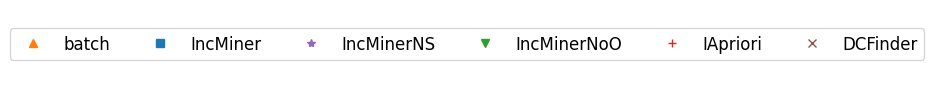

In [16]:
# Create legend elements, skipping "IncMiner1.0"
legend_elements = [
    plt.Line2D([0], [0], color=colorMap[label], marker=markerMap[label], 
                # markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                # markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
               linestyle='', label=label)
    for label in colorMap.keys() if label != "IncMiner1.0"
]

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 1))  # Adjust width and height for a wide flat layout

# Remove axes
ax.axis('off')

# Add the legend
ax.legend(
    handles=legend_elements,
    loc='center',
    frameon=True,
    fontsize=12,
    ncol=len(legend_elements),  # Arrange all legend entries in a single row
)

# Adjust layout
plt.tight_layout()

# Save or display the legend-only plot
plt.savefig("plots/legend.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [17]:
ylabel_time = "Running time (s)"

In [9]:
def post_process(_df):
    # 1. Compute scale factor of 'new support' over 'old support'
    _df['supportScale'] = _df['new support'] / _df['old support']

    # 2. Compute absolute difference of 'new confidence' over 'old confidence'
    _df['confDiff'] = _df['new confidence'] - _df['old confidence']
    
    # 3. Assign new label name
    _df['label'] = _df['Baseline'] + _df['beta'].fillna('').astype(str)
    
    # 4. Convert Mining time scale, but leave as is if 'timeout'
    _df['time'] = _df['Mining time'].apply(
        lambda x: max(x,1000) / 1000 if isinstance(x, (int, float)) else x
    )

    return _df

In [10]:
def compute_speedup(df, baseline_label, target_labels, metric="time"):
    """
    Compute the maximal and average speedup for target labels compared to a baseline label,
    replacing zero values with 1 to avoid division errors.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing timing data.
        baseline_label (str): The label of the baseline group (e.g., 'batch').
        target_labels (list): A list of labels for the groups to compare against the baseline.
    
    Returns:
        dict: A dictionary with the speedup results for each target label.
    """
    # Group by the "label" column
    groups = df.groupby('label')
    
    # Extract baseline times
    if baseline_label not in groups.groups:
        raise ValueError(f"Baseline label '{baseline_label}' not found in data.")
    
    # times_baseline = groups.get_group(baseline_label)['time'].replace(0, 1).values  # Replace 0 with 1
    times_baseline = groups.get_group(baseline_label)[metric].apply(lambda x: max(x, 1)).values  # Replace values < 1 with 1

    
    # Initialize results dictionary
    speedup_results = {}
    
    # Compute speedup for each target label
    for label in target_labels:
        if label not in groups.groups:
            print(f"Warning: Target label '{label}' not found in data. Skipping.")
            continue
        
        # times_target = groups.get_group(label)['time'].replace(0, 1).values  # Replace 0 with 1
        times_target = groups.get_group(label)[metric].apply(lambda x: max(x, 1)).values  # Replace values < 1 with 1

        
        # Ensure the baseline and target have the same number of entries
        if len(times_baseline) != len(times_target):
            raise ValueError(f"Mismatch in number of entries for baseline '{baseline_label}' and target '{label}'.")
        
        # Calculate speedup
        speedups = times_baseline / times_target
        
        # Store results
        speedup_results[label] = {
            "max_speedup": speedups.max(),
            "avg_speedup": speedups.mean()
        }
    
    return speedup_results

# Exp-1-a

In [56]:
def pre_process_exp1(_df):
    # 1. Compute scale factor of 'new support' over 'old support'
    _df['etaDiff'] = _df['new eta'] - _df['old eta']

    # 4. Convert Mining time scale, but leave as is if 'timeout'
    _df['time'] = _df['Mining time'].apply(
        lambda x: max(x,1000) / 1000 if isinstance(x, (int, float)) else x
    )

    return _df

In [77]:
tab = 'Δ𝜂 > 0 in X'
df = dfs[tab]
df = pre_process_exp1(df)

IncMiner
IncMinerNS
IncMinerNoO
batch


/var/folders/mv/j_58gf917nd0c2nczfjyc3900000gn/T/ipykernel_31752/1991729185.py:29: UserWarning: Glyph 120578 (\N{MATHEMATICAL ITALIC SMALL ETA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/mv/j_58gf917nd0c2nczfjyc3900000gn/T/ipykernel_31752/1991729185.py:30: UserWarning: Glyph 120578 (\N{MATHEMATICAL ITALIC SMALL ETA}) missing from font(s) DejaVu Sans.
  plt.savefig(outfile, bbox_inches='tight')
/var/folders/mv/j_58gf917nd0c2nczfjyc3900000gn/T/ipykernel_31752/1991729185.py:30: UserWarning: Glyph 120578 (\N{MATHEMATICAL ITALIC SMALL ETA}) missing from font(s) DejaVu Sans.
  plt.savefig(outfile, bbox_inches='tight')
/Users/hxc/Google/projects/sigmod-results/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 120578 (\N{MATHEMATICAL ITALIC SMALL ETA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


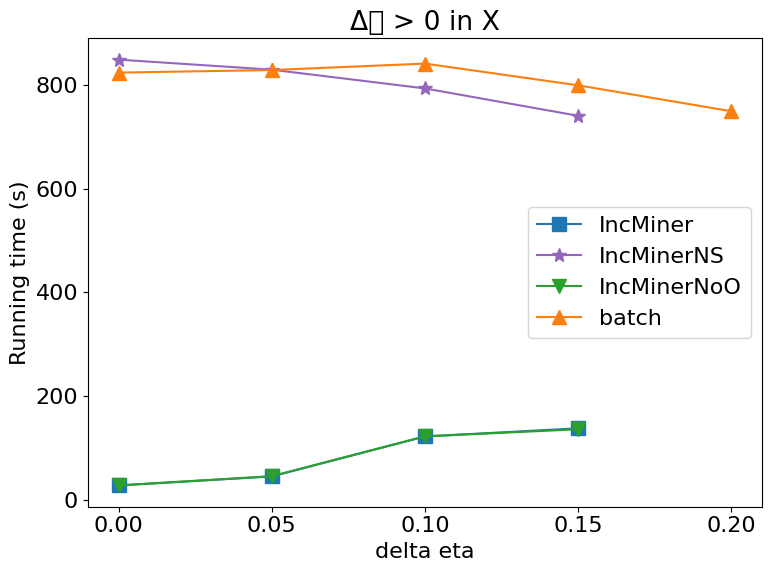

In [78]:

# Group by the "label" column
groups = df.groupby('Baseline')

# Create a plot for each group
plt.figure()

for label, group in groups:
    print (label)
    X = group['etaDiff']
    # print (group['time'])
    plt.plot(range(len(X)), group['time'], label=label, marker=markerMap[label],color=colorMap[label],
                # markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                # markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
                # markersize=markerStyleMap[label].get('markersize', 10)
            ) 
    
# Add plot labels and legend
plt.ylabel('Running time (s)')  # Label for y-axis

xtick_labels = [f"{value:.2f}" for value in X]
plt.xticks(range(len(X)), xtick_labels)

if VERBOSE:
    plt.xlabel('delta eta')  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_hospital_eta_X_increase.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show() 

## exp1-b

In [79]:
tab = 'Δ𝜂 < 0 in X'
df = dfs[tab]
df = pre_process_exp1(df)

IncMiner
IncMinerNS
IncMinerNoO
batch


/var/folders/mv/j_58gf917nd0c2nczfjyc3900000gn/T/ipykernel_31752/1189143810.py:29: UserWarning: Glyph 120578 (\N{MATHEMATICAL ITALIC SMALL ETA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/mv/j_58gf917nd0c2nczfjyc3900000gn/T/ipykernel_31752/1189143810.py:30: UserWarning: Glyph 120578 (\N{MATHEMATICAL ITALIC SMALL ETA}) missing from font(s) DejaVu Sans.
  plt.savefig(outfile, bbox_inches='tight')
/var/folders/mv/j_58gf917nd0c2nczfjyc3900000gn/T/ipykernel_31752/1189143810.py:30: UserWarning: Glyph 120578 (\N{MATHEMATICAL ITALIC SMALL ETA}) missing from font(s) DejaVu Sans.
  plt.savefig(outfile, bbox_inches='tight')
/Users/hxc/Google/projects/sigmod-results/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 120578 (\N{MATHEMATICAL ITALIC SMALL ETA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


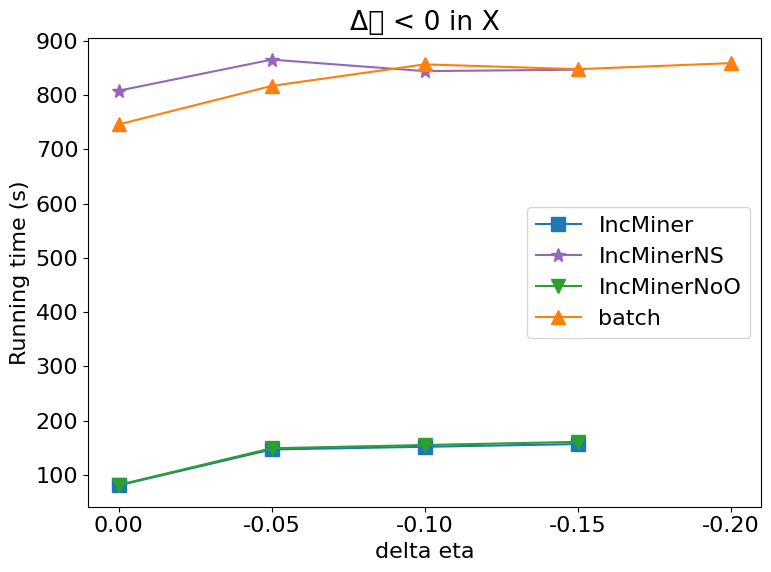

In [81]:
# Group by the "label" column
groups = df.groupby('Baseline')

# Create a plot for each group
plt.figure()

for label, group in groups:
    print (label)
    X = group['etaDiff']
    # print (group['time'])
    plt.plot(range(len(X)), group['time'], label=label, marker=markerMap[label],color=colorMap[label],
                # markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                # markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
                # markersize=markerStyleMap[label].get('markersize', 10)
            ) 
    
# Add plot labels and legend
plt.ylabel('Running time (s)')  # Label for y-axis

xtick_labels = [f"{value:.2f}" for value in X]
plt.xticks(range(len(X)), xtick_labels)

if VERBOSE:
    plt.xlabel('delta eta')  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_hospital_eta_X_increase.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show() 

## exp1-c

In [24]:
tab = 'Δ𝜂 > 0 in 𝑝0'
df = dfs[tab]
df = pre_process_exp1(df)

IncMiner
IncMinerNS
IncMinerNoO
batch


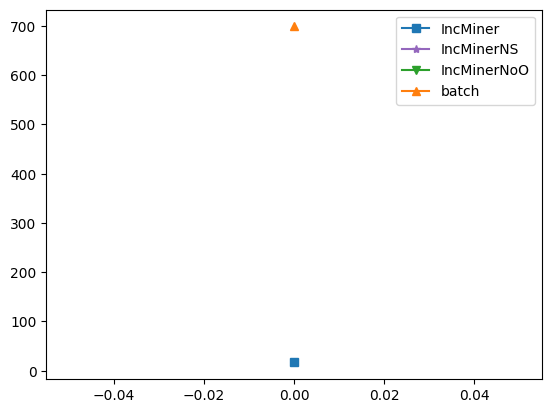

In [25]:
# Group by the "label" column
groups = df.groupby('Baseline')

# Create a plot for each group
plt.figure()

for label, group in groups:
    print (label)
    X = group['Baseline']
    # print (group['time'])
    plt.plot(range(len(X)), group['time'], label=label, marker=markerMap[label],color=colorMap[label],
                # markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                # markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
                # markersize=markerStyleMap[label].get('markersize', 10)
            ) 
plt.legend()